In [1]:
import numpy as np
import pandas as pd

In [2]:
# Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
train_gen = ImageDataGenerator(rescale=(1./255),horizontal_flip=True,shear_range=0.2)
test_gen = ImageDataGenerator(rescale=(1./255))  #--> (0 to 255) convert to (0 to 1)

In [4]:
train = train_gen.flow_from_directory('Dataset(original)/train',
                                      target_size=(224, 224),
                                      class_mode='categorical', 
                                      batch_size=8)
test = test_gen.flow_from_directory('Dataset(original)/test',
                                    target_size=(224, 224),
                                      class_mode='categorical', 
                                      batch_size=8)

Found 655 images belonging to 17 classes.
Found 183 images belonging to 17 classes.


In [5]:
train.class_indices

{'Darier_s disease': 0,
 'Muehrck-e_s lines': 1,
 'aloperia areata': 2,
 'beau_s lines': 3,
 'bluish nail': 4,
 'clubbing': 5,
 'eczema': 6,
 'half and half nailes (Lindsay_s nails)': 7,
 'koilonychia': 8,
 'leukonychia': 9,
 'onycholycis': 10,
 'pale nail': 11,
 'red lunula': 12,
 'splinter hemmorrage': 13,
 'terry_s nail': 14,
 'white nail': 15,
 'yellow nails': 16}

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
# Set hyperparameters and configurations
num_classes = 17
batch_size = 32
learning_rate = 0.001
num_epochs = 30

In [8]:
# Define your DenseNet-VGG16 hybrid model architecture
def DenseNetVGG16(num_classes):
    # Load pre-trained DenseNet and VGG16 models
    densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the pre-trained layers
    for layer in densenet.layers:
        layer.trainable = False
    for layer in vgg16.layers:
        layer.trainable = False

    # Combine DenseNet and VGG16 models
    input_layer = tf.keras.Input(shape=(224, 224, 3))
    densenet_output = densenet(input_layer)
    vgg16_output = vgg16(input_layer)

    # Add global average pooling layer
    densenet_output = GlobalAveragePooling2D()(densenet_output)
    vgg16_output = GlobalAveragePooling2D()(vgg16_output)

    # Concatenate DenseNet and VGG16 outputs
    combined_output = tf.keras.layers.concatenate([densenet_output, vgg16_output])

    # Add a fully connected layer
    dense = Dense(units=128, activation='relu')(combined_output)

    # Add output layer
    output = Dense(units=num_classes, activation='softmax')(dense)

    # Create the model
    model = Model(inputs=input_layer, outputs=output)
    
    return model

In [9]:
# Load and preprocess the nail image dataset
# Ensure that you have a data generator providing batches of image-label pairs
# Initialize your DenseNet-VGG16 hybrid model
model = DenseNetVGG16(num_classes)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 densenet121 (Functional)       (None, 7, 7, 1024)   7037504     ['input_3[0][0]']                
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['input_3[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 1024)        0           ['densenet121[0][0]']        

In [11]:
# Create the optimizer with a specific learning rate
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)

In [13]:
# Train the model
history = model.fit(train,epochs=num_epochs,validation_data=test, callbacks=[early_stopping])

Epoch 1/30
82/82 [==============================] - 103s 1s/step - loss: 2.8062 - accuracy: 0.1252 - val_loss: 2.4391 - val_accuracy: 0.2459
Epoch 2/30
82/82 [==============================] - 101s 1s/step - loss: 2.2913 - accuracy: 0.2870 - val_loss: 2.0873 - val_accuracy: 0.3224
Epoch 3/30
82/82 [==============================] - 104s 1s/step - loss: 1.9167 - accuracy: 0.4168 - val_loss: 1.6806 - val_accuracy: 0.4699
Epoch 4/30
82/82 [==============================] - 104s 1s/step - loss: 1.6047 - accuracy: 0.5267 - val_loss: 1.3689 - val_accuracy: 0.6175
Epoch 5/30
82/82 [==============================] - 105s 1s/step - loss: 1.4038 - accuracy: 0.5802 - val_loss: 1.2058 - val_accuracy: 0.6831
Epoch 6/30
82/82 [==============================] - 106s 1s/step - loss: 1.2261 - accuracy: 0.6565 - val_loss: 1.1534 - val_accuracy: 0.6284
Epoch 7/30
82/82 [==============================] - 106s 1s/step - loss: 1.0727 - accuracy: 0.6977 - val_loss: 0.8506 - val_accuracy: 0.7486
Epoch 8/30
82

In [14]:
# Save the trained model
model.save('DenseNetVGG16.h5')

In [15]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [16]:
model = load_model('DenseNetVGG16.h5')

In [24]:
img=image.load_img('Dataset-3/Test/Leukonychia/21.PNG',target_size=(224,224))

In [25]:
img = image.img_to_array(img)
img = np.expand_dims(img,axis=0)
model.predict(img)
pred = np.argmax(model.predict(img))
output = ['Darier_s disease','Muehrck-e_s lines','Onychogryphosis','Onycholycis_NailPsoriasis',
          'aloperia areata','beau_s lines','bluish nail', 'clubbing','eczema','half and half nailes (Lindsay_s nails)',
          'koilonychia','leukonychia','pale nail','red lunula',
          'splinter hemmorrage_Acral Lentiginous Melanoma',
          'terry_s nail_WhiteNails','yellow nails']
print(output[pred])

1/1 [==============================] - 0s 137ms/step
terry_s nail_WhiteNails


In [16]:
import matplotlib.pyplot as plt

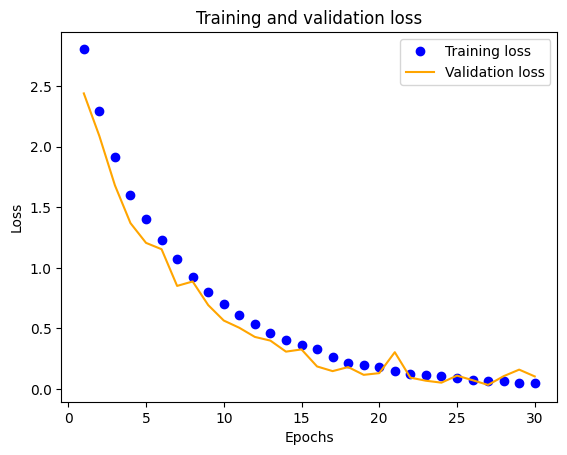

In [17]:
# let's see the training and validation accuracy by epoch
history_dict = history.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()